# **Práctica 2: Sensado y análisis de video**
### Ciencia de Datos para Sensores Inteligentes
*Alumno: Norman O. Guzmán Chaboya*

In [72]:
import pyrealsense2 as rs
import numpy as np
import cv2
import os
from datetime import datetime
import pandas as pd

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from collections import deque

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

## **Recolección Colectiva de Videos**

In [14]:
file_map = pd.read_csv('Etiquetas_nombres.csv')
file_map.head()

,label,id,filename,num
0,Diana_Itzel,Diana_Itzel_01,grabacion_20260206_140603.bag,140603
1,Diana_Itzel,Diana_Itzel_02,grabacion_20260206_140652.bag,140652
2,Diana_Itzel,Diana_Itzel_03,grabacion_20260206_140722.bag,140722
3,Diana_Itzel,Diana_Itzel_04,grabacion_20260206_140800.bag,140800
4,Zarif,Zarif_01,grabacion_20260206_140924.bag,140924


## **Extracción de Puntos CLave**

In [15]:
POSE_LABELS = {
        11: "hombro_Izq", 12: "hombro_Der", 
        13: "codo_Izq", 14: "codo_Der", 
        15: "muneca_Izq", 16: "muneca_Der",
        23: "cadera_izq", 24: "cadera_der",
        25: "rodilla_izq", 26: "rodilla_der",
        27: "tobillo_izq", 28: "tobillo_der"
    }

ts = [0]
keypoints = [0.0] * 36
metadata = ['filename_placeholder', 'id_placeholder', 'label_placeholder']
empty_vector = metadata + ts + keypoints

# Intialize columns
columns = ['filename', 'id', 'label', 'frame']

# Loop through the POSE_LABELS to create x, y, z headers for each body part
for label in POSE_LABELS.values():
    columns.extend([f"{label}_x", f"{label}_y", f"{label}_z"])

# Add the final metadata columns
vector_map_df = pd.DataFrame([empty_vector], columns=columns)
    
#print(vector_map)

In [18]:
def extract_keypoints(filename, id_, label):
    # --- CONFIGURACIÓN ---
    FRAME_RATE = 30

    # PARA ESTE CASO PARTICUALR, SE TOMARON 12 KEYPOINTS CORRESPONDIENTES
    # A ARTICULACIONES DE EXTREMIDADES
    POSE_LABELS = {
        11: "hombro_Izq", 12: "hombro_Der", 
        13: "codo_Izq", 14: "codo_Der", 
        15: "muneca_Izq", 16: "muneca_Der",
        23: "cadera_izq", 24: "cadera_der",
        25: "rodilla_izq", 26: "rodilla_der",
        27: "tobillo_izq", 28: "tobillo_der"
    }
    
    POSE_CONNECTIONS = [
        (11, 12), (11, 13), (13, 15), (12, 14), (14, 16),
        (11, 23), (12, 24), (23, 24), (24, 26), (26, 28), 
        (23, 25), (25, 27)
    ]

    FILENAME = filename
    ID = id_
    LABEL = label
    
    filtros_z = {point_id: deque(maxlen=5) for point_id in POSE_LABELS.keys()}
    archivo_bag = f"./grabaciones/{FILENAME}"
    nombre_salida = f"./videos_poses/{ID}_poses.mp4"
    
    # --- CONFIGURAR VIDEO WRITER ---
    # Definimos el codec y creamos el objeto VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(nombre_salida, fourcc, FRAME_RATE, (1280, 720))
    
    # --- INICIALIZAR MODELO (Pose) ---
    base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
    options = vision.PoseLandmarkerOptions(base_options=base_options)
    detector = vision.PoseLandmarker.create_from_options(options)
    
    # --- CONFIGURAR REALSENSE ---
    pipeline = rs.pipeline()
    config = rs.config()
    rs.config.enable_device_from_file(config, archivo_bag)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, FRAME_RATE)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, FRAME_RATE)
    
    profile = pipeline.start(config)
    playback = profile.get_device().as_playback()
    playback.set_real_time(False) 
    align = rs.align(rs.stream.color)
    
    duration = playback.get_duration()
    t_frame_count = int(duration.total_seconds()*FRAME_RATE)
    #print(t_frame_count)
    
    stop = False
    frame_count = 0
    prev_detected = False
    start = False
    end = False
    check_id1 = 27
    check_id2 = 28
    vector_map = []
    
    try:
        print(f"Procesando y guardando en {nombre_salida}...")
        while True:
            frames = pipeline.wait_for_frames()
            aligned_frames = align.process(frames)
            depth_frame = aligned_frames.get_depth_frame()
            color_frame = aligned_frames.get_color_frame()
            if not depth_frame or not color_frame: break
    
            frame_count += 1
            # Get current position in nanoseconds
            #print(frame_count)
    
            color_image = np.asanyarray(color_frame.get_data())
            
            # MediaPipe Detection
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
            detection_result = detector.detect(mp_image)
    
            # 1. Dibujar HUD
            overlay = color_image.copy()
            cv2.rectangle(overlay, (1000, 10), (1270, 360), (0, 0, 0), -1)
            cv2.addWeighted(overlay, 0.6, color_image, 0.4, 0, color_image)
            cv2.putText(color_image, "TELEMETRIA POSE (m)", (1010, 35), 
                        cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 255), 1)
    
            if detection_result.pose_landmarks:
                # SE EMPIEZA A GRABAR AL DETECTAR UN FLUJO CONSTANTE DE DETECCIONES Y PARTIR DE LOS 
                # 3 SEGUNDOS DE INICIO DE LA PRUEBA
                if prev_detected and frame_count > 90: start = True
                prev_detected = True
                vector = []
                vector.append(FILENAME)
                vector.append(ID)
                vector.append(LABEL)
                vector.append(frame_count)
                
                for pose_landmarks in detection_result.pose_landmarks:
                    puntos_cuerpo = []
                    norm_puntos_cuerpo = []
                    for lm in pose_landmarks:
                        px = int(np.clip(lm.x * 1280, 0, 1279))
                        py = int(np.clip(lm.y * 720, 0, 719))
                        pz = depth_frame.get_distance(px, py)
                        puntos_cuerpo.append((px, py, pz))
                        norm_puntos_cuerpo.append((lm.x, lm.y, pz))
    
                    # 3. Dibujar Esqueleto
                    for conn in POSE_CONNECTIONS:
                        p1, p2 = puntos_cuerpo[conn[0]], puntos_cuerpo[conn[1]]
                        cv2.line(color_image, (p1[0], p1[1]), (p2[0], p2[1]), (255, 255, 255), 2)
    
                    # 4. Telemetría y Puntos
        
                    for idx, (point_id, name) in enumerate(POSE_LABELS.items()):
                        px, py, pz = puntos_cuerpo[point_id]
                        x, y, z = norm_puntos_cuerpo[point_id]
                        vector.append(x); vector.append(y); vector.append(z)
                        
                        if point_id == check_id1:
                            id1_z = pz
                        if point_id == check_id2:
                            id2_z = pz 
                            
                        cv2.circle(color_image, (px, py), 6, (0, 255, 0), -1)
                        #print(f"Index: {idx}")
    
                        if pz > 0: filtros_z[point_id].append(pz)
                            
                        if len(filtros_z[point_id]) > 0:
                            z_final = sum(filtros_z[point_id]) / len(filtros_z[point_id])
                            txt = f"{name}: {z_final:.3f}m"
                            color_txt = (255, 255, 255)
                        else:
                            txt = f"{name}: ---"
                            color_txt = (0, 0, 255)
    
                        cv2.putText(color_image, txt, (1010, 70 + (idx * 25)), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_txt, 1)
                        
                    if id1_z == 0 or id2_z == 0:
                        end = True
                    
                    if start and not end:
                        #print(f'Frame {frame_count}: {vector} (Continous or needing interpolation)')
                        vector_map.append(vector)
                        
                    else:
                        #print(f'Frame {frame_count}: {vector} (Invalid)')
                        True
                    
                    
            else:
                prev_detected = False
                #print(f"Frame {frame_count}: No detection")
    
            # --- GUARDAR FRAME ---
            out.write(color_image)
    
            # Mostrar en pantalla
            cv2.imshow('Grabando Pose...', color_image)
            if stop: break
            if frame_count == t_frame_count-15: break # BREAK 0.5 S ANTES DEL FIN
            if cv2.waitKey(1) & 0xFF == ord('q'): break
    
    
    finally:
        print("Finalizado. Liberando recursos...")
        pipeline.stop()
        out.release() # Es crucial cerrar el VideoWriter para que el archivo sea legible
        cv2.destroyAllWindows()
    return  pd.DataFrame(vector_map, columns=vector_map_df.columns)



In [19]:
for index, row in file_map.iterrows():
    vector_map = extract_keypoints(row["filename"], row["id"], row["label"])

    vector_map_df  = pd.concat([vector_map_df, pd.DataFrame(vector_map, columns=vector_map_df.columns)])

Procesando y guardando en ./videos_poses/Diana_Itzel_01_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Diana_Itzel_02_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Diana_Itzel_03_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Diana_Itzel_04_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Zarif_01_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Zarif_02_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Zarif_03_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Zarif_04_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Javier_01_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/Javier_02_poses.mp4...
Finalizado. Liberando recursos...
Proc

In [28]:
vector_map_df = vector_map_df.iloc[1:]

In [29]:
#print(vector_map)
# EL MAPA CONTEMPLA TODOS LOS DATAFRAMES, ANOTANDO COORDENADAS PARA CADA KEYPOINT Y SU PROFUNIDAD (DISTANCIA A REALSENSE)
vector_map_df

,filename,id,label,frame,hombro_Izq_x,hombro_Izq_y,hombro_Izq_z,hombro_Der_x,hombro_Der_y,hombro_Der_z,...,rodilla_izq_z,rodilla_der_x,rodilla_der_y,rodilla_der_z,tobillo_izq_x,tobillo_izq_y,tobillo_izq_z,tobillo_der_x,tobillo_der_y,tobillo_der_z
0,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,113,0.422649,0.367326,10.992001,0.399982,0.378239,18.524,...,5.466,0.361073,0.603836,4.977,0.366278,0.661219,4.674,0.373199,0.687199,4.142
1,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,130,0.425136,0.356366,18.524,0.464649,0.356525,6.044,...,6.392,0.460163,0.498137,6.691,0.438934,0.553063,6.454,0.458211,0.539362,6.474
2,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,131,0.435564,0.357498,5.972,0.465212,0.356395,5.919,...,8.233001,0.458169,0.473866,6.454,0.441875,0.538964,5.99,0.457563,0.526299,6.559
3,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,134,0.424106,0.358903,16.005001,0.462177,0.363481,5.833,...,7.044,0.458875,0.492301,6.232,0.436405,0.586296,6.232,0.457711,0.54842,6.331
4,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,136,0.432537,0.364496,5.937,0.462231,0.362863,5.749,...,5.867,0.457981,0.46932,5.954,0.444051,0.559149,5.765,0.462003,0.517777,6.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,grabacion_20260206_151401.bag,Hussein_04,Hussein,250,0.427091,0.500416,2.23,0.347577,0.515655,2.156,...,2.261,0.390864,0.801645,2.467,0.43254,0.971286,2.261,0.398981,0.849315,2.605
75,grabacion_20260206_151401.bag,Hussein_04,Hussein,251,0.427824,0.507451,2.172,0.347167,0.524144,2.093,...,2.23,0.389253,0.805369,2.422,0.429558,0.980705,2.255,0.398477,0.851007,2.422
76,grabacion_20260206_151401.bag,Hussein_04,Hussein,252,0.430173,0.513919,2.124,0.349158,0.527786,0.0,...,2.206,0.389895,0.814745,2.332,0.42849,0.986997,2.22,0.39784,0.847827,2.449
77,grabacion_20260206_151401.bag,Hussein_04,Hussein,253,0.432618,0.51619,2.091,0.35055,0.532302,2.05,...,2.158,0.389503,0.820344,2.253,0.429079,0.990778,2.211,0.396537,0.856005,2.542


In [78]:
vector_map_df.to_csv("map_coords.csv", index=False)

In [79]:
vm_df = pd.read_csv('map_coords.csv')

### Normalización

In [80]:
def normalize_xy(df):
    df_norm = df.copy()
    
    # TOMAMOS LA CADERA COMO PUNTO CENTRAL PARA NORMALIZAR (VECTORIZADA)
    hip_center_x = (df_norm['cadera_izq_x'] + df_norm['cadera_der_x']) / 2
    hip_center_y = (df_norm['cadera_izq_y'] + df_norm['cadera_der_y']) / 2
    
    # GUARDAMOS EL CENTRO
    df_norm['hip_center_x'] = hip_center_x
    df_norm['hip_center_y'] = hip_center_y
    
    # SE ENLISTAN TODAS LAS COLUMNAS DE X, Y PARA NORMALIZAR
    xy_columns = [col for col in df_norm.columns 
                  if col.endswith('_x') or col.endswith('_y')]
    
    # SE SUBSTRAE EL VALOR CENTRAL
    for col in xy_columns:
        if col.endswith('_x'):
            df_norm[col] = df_norm[col] - hip_center_x
        elif col.endswith('_y'):
            df_norm[col] = df_norm[col] - hip_center_y
    
    return df_norm

In [81]:
vm_df_normalized = normalize_xy(vm_df)
vm_df_normalized

,filename,id,label,frame,hombro_Izq_x,hombro_Izq_y,hombro_Izq_z,hombro_Der_x,hombro_Der_y,hombro_Der_z,...,rodilla_der_y,rodilla_der_z,tobillo_izq_x,tobillo_izq_y,tobillo_izq_z,tobillo_der_x,tobillo_der_y,tobillo_der_z,hip_center_x,hip_center_y
0,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,113,0.027489,-0.142334,10.992001,0.004822,-0.131421,18.524,...,0.094175,4.977,-0.028881,0.151559,4.674,-0.021960,0.177539,4.142,0.0,0.0
1,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,130,-0.021420,-0.071520,18.524000,0.018093,-0.071361,6.044,...,0.070251,6.691,-0.007623,0.125177,6.454,0.011655,0.111475,6.474,0.0,0.0
2,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,131,-0.015097,-0.064170,5.972000,0.014552,-0.065272,5.919,...,0.052198,6.454,-0.008786,0.117296,5.990,0.006902,0.104631,6.559,0.0,0.0
3,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,134,-0.022613,-0.087531,16.005001,0.015458,-0.082952,5.833,...,0.045867,6.232,-0.010314,0.139862,6.232,0.010993,0.101986,6.331,0.0,0.0
4,grabacion_20260206_140603.bag,Diana_Itzel_01,Diana_Itzel,136,-0.013276,-0.068438,5.937000,0.016418,-0.070071,5.749,...,0.036387,5.954,-0.001761,0.126216,5.765,0.016190,0.084843,6.495,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2336,grabacion_20260206_151401.bag,Hussein_04,Hussein,250,0.030549,-0.204333,2.230000,-0.048966,-0.189094,2.156,...,0.096896,2.467,0.035998,0.266537,2.261,0.002438,0.144566,2.605,0.0,0.0
2337,grabacion_20260206_151401.bag,Hussein_04,Hussein,251,0.031220,-0.207473,2.172000,-0.049437,-0.190780,2.093,...,0.090445,2.422,0.032955,0.265781,2.255,0.001873,0.136083,2.422,0.0,0.0
2338,grabacion_20260206_151401.bag,Hussein_04,Hussein,252,0.031761,-0.209695,2.124000,-0.049255,-0.195828,0.000,...,0.091131,2.332,0.030078,0.263383,2.220,-0.000572,0.124213,2.449,0.0,0.0
2339,grabacion_20260206_151401.bag,Hussein_04,Hussein,253,0.032628,-0.214706,2.091000,-0.049439,-0.198593,2.050,...,0.089448,2.253,0.029089,0.259882,2.211,-0.003452,0.125109,2.542,0.0,0.0


## Extracción de Características

In [90]:
def calculate_gait_metrics(df_raw, fps=30):
    dt = 1/fps
    rows = []
    
    parts = [
        "hombro_Izq", "hombro_Der", "codo_Izq", "codo_Der", 
        "muneca_Izq", "muneca_Der", "cadera_izq", "cadera_der", 
        "rodilla_izq", "rodilla_der", "tobillo_izq", "tobillo_der"
    ]

    # CALCULAMOS LA ACCELERACIÓN DE TODAS LAS ARTICULACIONES
    accel_dict = {}
    for part in parts:
        coords = df_raw[[f'{part}_x', f'{part}_y', f'{part}_z']].values
        vel = np.gradient(coords, dt, axis=0)
        accel = np.gradient(vel, dt, axis=0)
        accel_dict[part] = np.linalg.norm(accel, axis=1)

    new_data = {
        'frame': df_raw['frame'],
        
        # DISTANCIAS: HOMBROS A MUNECAS
        'dist_arm_izq': np.linalg.norm(df_raw[['hombro_Izq_x', 'hombro_Izq_y', 'hombro_Izq_z']].values - 
                                       df_raw[['muneca_Izq_x', 'muneca_Izq_y', 'muneca_Izq_z']].values, axis=1),
        'dist_arm_der': np.linalg.norm(df_raw[['hombro_Der_x', 'hombro_Der_y', 'hombro_Der_z']].values - 
                                       df_raw[['muneca_Der_x', 'muneca_Der_y', 'muneca_Der_z']].values, axis=1),
        
        # DISTANCIAS: CADERAS A TOBILLOS
        'dist_leg_izq': np.linalg.norm(df_raw[['cadera_izq_x', 'cadera_izq_y', 'cadera_izq_z']].values - 
                                       df_raw[['tobillo_izq_x', 'tobillo_izq_y', 'tobillo_izq_z']].values, axis=1),
        'dist_leg_der': np.linalg.norm(df_raw[['cadera_der_x', 'cadera_der_y', 'cadera_der_z']].values - 
                                       df_raw[['tobillo_der_x', 'tobillo_der_y', 'tobillo_der_z']].values, axis=1),
        
        # DISTANCIA: HOMBROS A TOBILLOS
        'dist_elbow_ankle_izq': np.linalg.norm(df_raw[['codo_Izq_x', 'codo_Izq_y', 'codo_Izq_z']].values - 
                                               df_raw[['tobillo_izq_x', 'tobillo_izq_y', 'tobillo_izq_z']].values, axis=1),
        'dist_elbow_ankle_der': np.linalg.norm(df_raw[['codo_Der_x', 'codo_Der_y', 'codo_Der_z']].values - 
                                               df_raw[['tobillo_der_x', 'tobillo_der_y', 'tobillo_der_z']].values, axis=1),
    }

    for part in parts:
        new_data[f'accel_{part}'] = accel_dict[part]

    new_data['filename'] = df_raw['filename']
    new_data['id'] = df_raw['id']
    new_data['label'] = df_raw['label']
    
    df = pd.DataFrame(new_data)

    dist_cols = [c for c in df.columns if 'dist_' in c]
    df[dist_cols] = df[dist_cols].rolling(window=3, center=True).mean()

    df = df.dropna()

    df_avg = df.drop(columns=['filename', 'id', 'label', 'frame']).mean().to_frame().T

    df_avg.insert(0, 'filename', df_raw['filename'].iloc[0])
    df_avg.insert(1, 'id', df_raw['id'].iloc[0])
    df_avg.insert(2, 'label', df_raw['label'].iloc[0])
    df_avg.insert(3, 'frame', 0)
    return df_avg
    

In [95]:
aux = vm_df_normalized[vm_df_normalized['id'] == 'Hussein_04']

In [91]:
test_df  = calculate_gait_metrics(aux)
test_df

,filename,id,label,frame,dist_arm_izq,dist_arm_der,dist_leg_izq,dist_leg_der,dist_elbow_ankle_izq,dist_elbow_ankle_der,...,accel_codo_Izq,accel_codo_Der,accel_muneca_Izq,accel_muneca_Der,accel_cadera_izq,accel_cadera_der,accel_rodilla_izq,accel_rodilla_der,accel_tobillo_izq,accel_tobillo_der
0,grabacion_20260206_151401.bag,Hussein_04,Hussein,0,0.305693,0.380962,0.373534,0.390112,1.014967,0.413992,...,373.659263,13.84826,15.449358,15.625099,36.433618,24.533264,59.544424,31.946252,33.320958,27.418415


In [92]:
id_list = vm_df_normalized['id'].unique()
columns = test_df.columns
features_df = pd.DataFrame(columns=columns)

for id_ in id_list:
    aux = vm_df_normalized[vm_df_normalized['id'] == id_]
    df = calculate_gait_metrics(aux)

    features_df = pd.concat([features_df, df])


In [98]:
features_df = features_df.dropna()
features_df = features_df.drop(columns=['filename', 'id','frame'])
features_df

,label,dist_arm_izq,dist_arm_der,dist_leg_izq,dist_leg_der,dist_elbow_ankle_izq,dist_elbow_ankle_der,accel_hombro_Izq,accel_hombro_Der,accel_codo_Izq,accel_codo_Der,accel_muneca_Izq,accel_muneca_Der,accel_cadera_izq,accel_cadera_der,accel_rodilla_izq,accel_rodilla_der,accel_tobillo_izq,accel_tobillo_der
0,Diana_Itzel,0.492908,0.256129,0.33652,0.451249,0.425369,0.501776,169.209237,154.559838,28.285972,54.777423,35.141335,57.851647,80.426577,50.115959,117.702923,56.322566,65.914057,76.118348
0,Diana_Itzel,0.288392,0.200522,0.322958,0.445353,0.488051,0.501783,9.43539,13.894598,85.732105,10.773416,76.234401,12.890028,16.699679,13.452046,31.59162,15.009461,32.066945,18.962482
0,Diana_Itzel,0.307642,0.184255,0.332193,0.453064,0.436819,0.494985,15.615699,18.563913,14.20963,12.303819,117.646728,16.766616,20.715249,17.487742,30.59902,25.963235,39.761398,28.033395
0,Diana_Itzel,0.206637,0.149645,0.298004,0.496674,0.347883,0.510772,55.009009,56.851302,30.824251,70.923052,62.673469,95.981912,47.90135,87.645472,53.706845,74.908904,108.440199,72.539406
0,Zarif,0.202451,0.196185,0.378103,0.388788,0.510442,0.5478,38.883097,35.536375,114.084588,176.980251,31.143024,13.71183,33.108612,53.603525,37.304717,46.859,34.217492,49.846272
0,Zarif,0.212641,0.330776,0.379722,0.374148,0.689096,0.599315,41.77249,52.837392,234.424522,196.498978,44.083959,125.339389,39.259011,47.993112,58.96201,68.249307,55.463961,80.934142
0,Zarif,0.804357,0.216379,0.461192,0.32239,0.525157,0.367161,21.234555,15.992289,23.187953,22.006304,522.167608,19.313327,31.689687,18.829115,39.7987,51.095607,39.163365,36.571651
0,Zarif,0.191231,0.191065,0.324718,0.460413,0.676498,0.5979,69.612452,62.546951,254.292588,286.945638,77.470219,56.474362,68.836898,244.290882,268.450751,107.858914,57.519673,91.67258
0,Javier,0.969158,0.177461,0.903366,0.395191,0.750126,0.363981,80.220556,117.175417,162.480631,36.013628,268.253125,41.90948,37.1815,134.452281,201.621829,223.933202,300.743509,100.019683
0,Javier,0.67214,0.312201,0.404255,0.629172,0.50797,0.553785,40.425863,61.528106,131.935405,49.637287,388.670788,79.167117,72.315975,131.965975,68.765467,110.430579,54.73962,82.188827


## **Construcción y evaluación de modelos**

In [101]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors  import KNeighborsClassifier  
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [126]:

x = features_df.iloc[:, 1:]
y = features_df['label']

In [129]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model1 = DecisionTreeClassifier()

fold_accuracies = []


for train_index, test_index in kf.split(x):

    X_train_fold, X_test_fold = x.iloc[train_index], x.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    

    model1.fit(X_train_fold, y_train_fold)
    y_pred = model1.predict(X_test_fold)
    
    # Evaluate
    acc = f1_score(y_test_fold, y_pred, average='macro')
    fold_accuracies.append(acc)
print(f"F-1 Score promedio a través de 5 pliegues: {np.mean(fold_accuracies):.2%}")


F-1 Score promedio a través de 5 pliegues: 7.82%


In [130]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model2 =  MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

fold_accuracies = []


for train_index, test_index in kf.split(x):

    X_train_fold, X_test_fold = x.iloc[train_index], x.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    

    model2.fit(X_train_fold, y_train_fold)
    y_pred = model2.predict(X_test_fold)
    
    # Evaluate
    acc = f1_score(y_test_fold, y_pred, average='macro')
    fold_accuracies.append(acc)
print(f"F-1 Score promedio a través de 5 pliegues: {np.mean(fold_accuracies):.2%}")

F-1 Score promedio a través de 5 pliegues: 5.24%


In [133]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model3 =  DecisionTreeClassifier()

fold_accuracies = []


for train_index, test_index in kf.split(x):

    X_train_fold, X_test_fold = x.iloc[train_index], x.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    

    model3.fit(X_train_fold, y_train_fold)
    y_pred = model3.predict(X_test_fold)
    
    # Evaluate
    acc = f1_score(y_test_fold, y_pred, average='macro')
    fold_accuracies.append(acc)
print(f"F-1 Score promedio a través de 5 pliegues: {np.mean(fold_accuracies):.2%}")

F-1 Score promedio a través de 5 pliegues: 10.81%


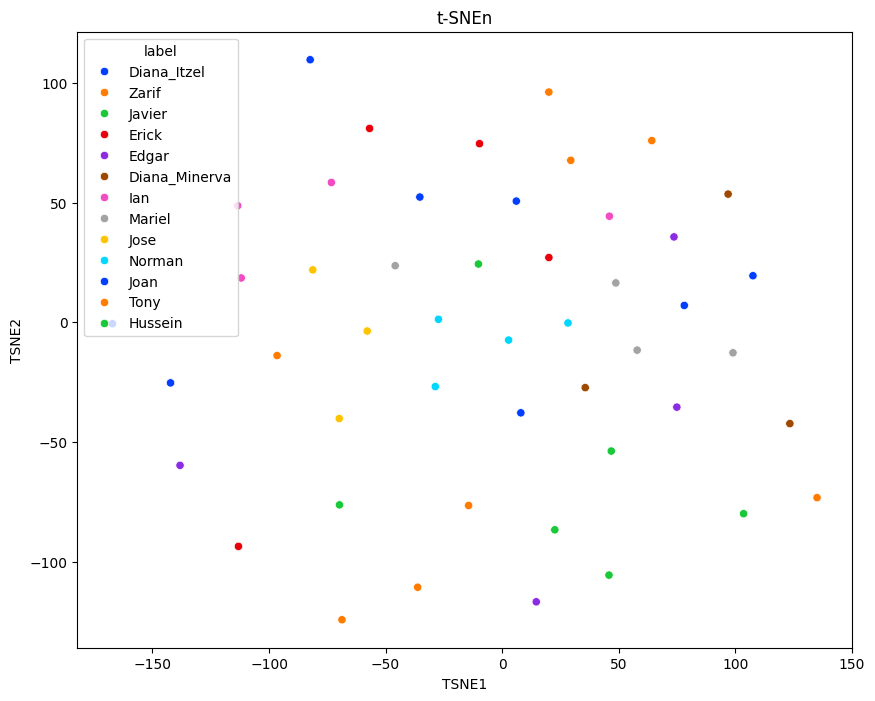

In [141]:


tsne = TSNE(
    n_components=2,
    perplexity=30,         # Balances local vs global aspects
    learning_rate=200,     # Learning rate
    random_state=42,
)

X_tsne = tsne.fit_transform(x)

tsne_df = pd.DataFrame(
    X_tsne, 
    columns=['TSNE1', 'TSNE2']
)

if y is not None:
    tsne_df['label'] = y

plt.figure(figsize=(10, 8))
if 'label' in tsne_df.columns:
    sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='label', palette='bright')
else:
    sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2')
plt.title('t-SNEn')
plt.show()

El t-SNE muestra que las instancias de diferentes CLASES (diferentes personas) ocupan el mismo espacio vectorial. Al no haber fronteras claras o clusters definidos, el árbol de decisión no puede generar reglas (if-else) que separen las etiquetas con precisión.
Debido a la dispersión observada en el t-SNE, el modelo está probablemente 'adivinando' o clasificando todo hacia la clase mayoritaria. Existe una dispersión de datos mezclada, como se observa arriba, lo que incurre en que el modelo termine detectando un número muy alto tanto de falsos positivos como de falsos negativos


## **Validación Externa**

In [142]:
file_map = pd.read_csv('etiquetas_nombres_val.csv')
file_map

,label,id,filename,num
0,unknown,unknown_1,grabacion_20260206_163238.bag,1
1,unknown,unknown_2,grabacion_20260206_163329.bag,2
2,unknown,unknown_3,grabacion_20260206_163516.bag,3
3,unknown,unknown_4,grabacion_20260206_163718.bag,4
4,unknown,unknown_5,grabacion_20260206_163827.bag,5
5,unknown,unknown_6,grabacion_20260206_163934.bag,6
6,unknown,unknown_7,grabacion_20260206_164008.bag,7
7,unknown,unknown_8,grabacion_20260206_164123.bag,8
8,unknown,unknown_9,grabacion_20260206_164209.bag,9
9,unknown,unknown_10,grabacion_20260206_164242.bag,10


In [143]:
for index, row in file_map.iterrows():
    vector_map = extract_keypoints(row["filename"], row["id"], row["label"])

    vector_map_df  = pd.concat([vector_map_df, pd.DataFrame(vector_map, columns=vector_map_df.columns)])
vector_map_df = vector_map_df.iloc[1:]
vector_map_df.to_csv("map_coords_validation.csv", index=False)

Procesando y guardando en ./videos_poses/unknown_1_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_2_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_3_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_4_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_5_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_6_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_7_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_8_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_9_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guardando en ./videos_poses/unknown_10_poses.mp4...
Finalizado. Liberando recursos...
Procesando y guarda

In [146]:
vm_df = pd.read_csv('map_coords_validation.csv')
vm_df_normalized = normalize_xy(vm_df)
aux = vm_df_normalized[vm_df_normalized['id'] == 'unknown_1']


test_df  = calculate_gait_metrics(aux)

id_list = vm_df_normalized['id'].unique()
columns = test_df.columns
features_df = pd.DataFrame(columns=columns)

for id_ in id_list:
    aux = vm_df_normalized[vm_df_normalized['id'] == id_]
    df = calculate_gait_metrics(aux)

    features_df = pd.concat([features_df, df])
features_df = features_df.dropna()
features_df = features_df.drop(columns=['filename', 'id','frame'])
features_df

,label,dist_arm_izq,dist_arm_der,dist_leg_izq,dist_leg_der,dist_elbow_ankle_izq,dist_elbow_ankle_der,accel_hombro_Izq,accel_hombro_Der,accel_codo_Izq,accel_codo_Der,accel_muneca_Izq,accel_muneca_Der,accel_cadera_izq,accel_cadera_der,accel_rodilla_izq,accel_rodilla_der,accel_tobillo_izq,accel_tobillo_der
0,unknown,0.24035,0.201457,0.332956,0.359701,0.389622,0.453111,11.744582,9.186719,12.342819,49.999895,14.468329,9.25527,14.774672,14.835877,15.513182,20.529042,24.109951,25.672838
0,unknown,0.231064,0.228721,0.34063,0.269882,0.417291,0.342683,13.92115,10.963729,12.266412,15.243815,13.442507,20.48813,12.608351,17.53129,30.512283,24.173987,46.149605,30.604867
0,unknown,0.182859,0.19764,0.377121,0.295912,0.40522,0.376146,13.904206,14.646243,16.026654,13.781428,21.051887,16.629967,23.898704,26.439886,20.846695,21.845885,30.229943,39.303495
0,unknown,0.249447,0.208399,0.465775,0.389821,0.568685,0.403192,16.494889,9.017273,70.219917,12.948797,9.646679,12.484297,69.176594,17.726066,27.137895,19.709141,34.609353,30.719529
0,unknown,0.207186,0.071627,0.352143,0.517527,0.432366,0.568069,14.152082,11.282017,9.092279,8.098412,8.112992,8.272121,13.402951,13.915952,11.204564,12.820048,9.354716,9.565234
0,unknown,0.192049,0.181566,0.395507,0.424387,0.485759,0.360695,36.884225,47.341668,15.547205,13.624341,9.275621,11.613887,27.624551,27.735049,34.718365,24.847098,39.775362,19.093324
0,unknown,0.214502,0.333311,0.446555,0.390142,0.521401,0.355751,12.122191,13.340752,12.765963,8.679173,8.02292,121.618912,13.113303,14.337806,17.906153,55.660544,13.235567,25.998818
0,unknown,0.213841,0.208751,0.454279,0.395638,0.558246,0.444566,12.8401,13.896059,6.766487,9.714585,9.152882,7.218274,12.85035,16.181299,98.69608,43.587603,21.943357,24.880122
0,unknown,0.223731,0.249422,0.372659,0.343809,0.520921,0.327164,10.969193,12.966235,8.985069,10.649613,8.511119,9.935257,21.323889,22.135531,116.526972,24.547983,31.445636,30.60138
0,unknown,0.160547,0.262402,0.401386,0.358024,0.526738,0.387393,8.431682,7.175302,10.403769,12.543927,7.988333,76.611864,19.670643,11.5023,92.180975,17.970783,26.435385,32.233163


In [148]:
x = features_df.iloc[:, 1:]

y_pred = model3.predict(x)

#print(y_pred)

m = pd.read_csv('etiquetas_nombres_val.csv')
m['predicted'] = y_pred
m

,label,id,filename,num,predicted
0,unknown,unknown_1,grabacion_20260206_163238.bag,1,Norman
1,unknown,unknown_2,grabacion_20260206_163329.bag,2,Hussein
2,unknown,unknown_3,grabacion_20260206_163516.bag,3,Norman
3,unknown,unknown_4,grabacion_20260206_163718.bag,4,Norman
4,unknown,unknown_5,grabacion_20260206_163827.bag,5,Edgar
5,unknown,unknown_6,grabacion_20260206_163934.bag,6,Edgar
6,unknown,unknown_7,grabacion_20260206_164008.bag,7,Hussein
7,unknown,unknown_8,grabacion_20260206_164123.bag,8,Hussein
8,unknown,unknown_9,grabacion_20260206_164209.bag,9,Mariel
9,unknown,unknown_10,grabacion_20260206_164242.bag,10,Norman
